In [3]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [6]:
print(os.listdir("c:/Users/hamsi/Desktop/Programming/AKCSE-Medical-Image-Analysis/imgClassification/data-input"))


['test', 'train']


In [7]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [10]:
filenames = os.listdir("c:/Users/hamsi/Desktop/Programming/AKCSE-Medical-Image-Analysis/imgClassification/data-input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [11]:
df.head()

,filename,category
0,cat.1 (1).jpg,1
1,cat.1 (10).jpg,1
2,cat.1 (11).jpg,1
3,cat.1 (12).jpg,1
4,cat.1 (13).jpg,1


In [12]:
df.tail()

,filename,category
153,sagittal. (95).png,0
154,sagittal. (96).png,0
155,sagittal. (97).png,0
156,sagittal. (98).png,0
157,sagittal. (99).png,0


<AxesSubplot:>

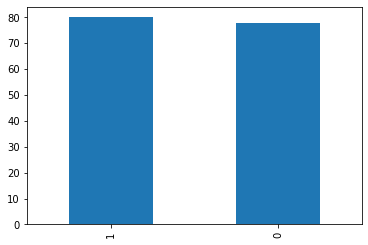

In [13]:
df['category'].value_counts().plot.bar()


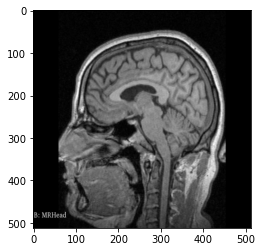

In [14]:
sample = random.choice(filenames)
image = load_img("c:/Users/hamsi/Desktop/Programming/AKCSE-Medical-Image-Analysis/imgClassification/data-input/train/"+sample)
plt.imshow(image)

In [15]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 classes -> cat & dog
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

In [16]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [17]:
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]
df["category"] = df["category"].replace({0: 'cat', 1: 'sagittal'}) 
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)




<AxesSubplot:>

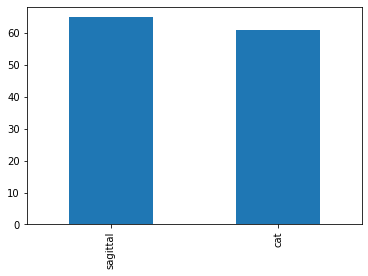

In [18]:
train_df['category'].value_counts().plot.bar()


<AxesSubplot:>

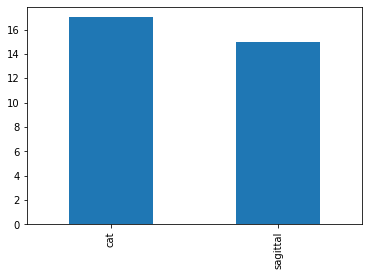

In [19]:
validate_df['category'].value_counts().plot.bar()


In [20]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)



train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "c:/Users/hamsi/Desktop/Programming/AKCSE-Medical-Image-Analysis/imgClassification/data-input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 126 validated image filenames belonging to 2 classes.


In [22]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "c:/Users/hamsi/Desktop/Programming/AKCSE-Medical-Image-Analysis/imgClassification/data-input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 32 validated image filenames belonging to 2 classes.


In [23]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "c:/Users/hamsi/Desktop/Programming/AKCSE-Medical-Image-Analysis/imgClassification/data-input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


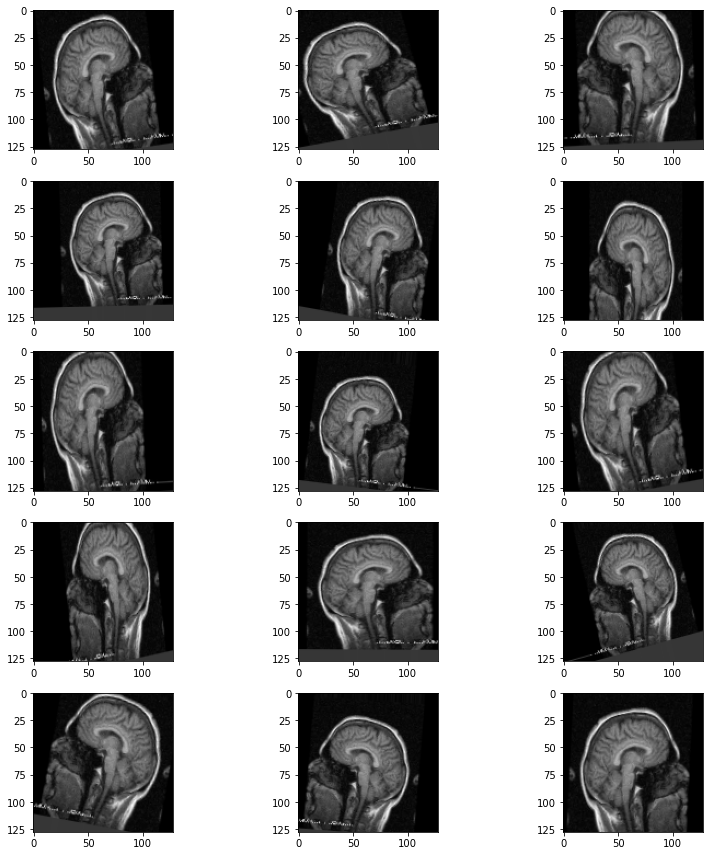

In [24]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [25]:
epochs=33
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

C:\Users\hamsi\anaconda3\envs\tf\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/33
8/8 [==============================] - 6s 582ms/step - loss: 1.0331 - accuracy: 0.7246 - val_loss: 1.0868 - val_accuracy: 0.5000
Epoch 2/33
8/8 [==============================] - 4s 495ms/step - loss: 0.1070 - accuracy: 0.9633 - val_loss: 0.5775 - val_accuracy: 0.6333
Epoch 3/33
8/8 [==============================] - 4s 517ms/step - loss: 0.2548 - accuracy: 0.9470 - val_loss: 1.0483 - val_accuracy: 0.5000
Epoch 4/33
8/8 [==============================] - 4s 507ms/step - loss: 0.2879 - accuracy: 0.8924 - val_loss: 1.4676 - val_accuracy: 0.5333
Epoch 5/33
8/8 [==============================] - 4s 506ms/step - loss: 0.2205 - accuracy: 0.9435 - val_loss: 2.2158 - val_accuracy: 0.5333
Epoch 6/33
8/8 [==============================] - 4s 472ms/step - loss: 0.0721 - accuracy: 0.9864 - val_loss: 0.4524 - val_accuracy: 0.9000
Epoch 7/33
8/8 [==============================] - 4s 473ms/step - loss: 0.0866 - accuracy: 0.9785 - val_loss: 3.3623 - val_accuracy: 0.5000
Epoch 8/33
8/8 [====

In [26]:
model.save_weights("static/cat_and_sagittal_model.h5")
